In [1]:
import dill 
import torch 
import torch.nn as nn
import numpy as np
from four_room.shortest_path import find_all_action_values
from four_room.env import FourRoomsEnv
from four_room.wrappers import gym_wrapper
import numpy as np
import imageio
import gymnasium as gym
from four_room.utils import obs_to_state
from four_room.arch import CNN
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


import warnings
warnings.filterwarnings(action='once')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
%load_ext autoreload
%autoreload 2

### Setting up the datasets

In [2]:
gym.register('MiniGrid-FourRooms-v1', FourRoomsEnv)
size = 19
with open('configs/train.pl', 'rb') as file:
    train_config = dill.load(file)

with open('configs/test_unreachable.pl', 'rb') as file:
    test_config = dill.load(file)

with open('configs/validation_unreachable.pl', 'rb') as file:
    val_config = dill.load(file)

In [3]:
env = gym_wrapper(gym.make(
        'MiniGrid-FourRooms-v1', 
        agent_pos= train_config['agent positions'],
        goal_pos = train_config['goal positions'],
        doors_pos = train_config['topologies'],
        agent_dir = train_config['agent directions'],
        size=size, 
        max_steps=1200, 
    ),
    original_obs=True
)

In [4]:
from collections import defaultdict

class Dataset:
    """Basic dataset class. Makes it easier to pickle the file. 
    """
    
    def __init__(self):
        self.X = []
        self.Y = []
        self.states = []
        
    def add(self, x, y, state):
        """Add a data sample to the dataset"""
        self.X.append(x)
        self.Y.append(y)
        self.states.append(state)
        
    def sort(self):
        """Returns a dictionary which for each q-vector returns the  
        corresponding states. 
        """             
        binned_dict = defaultdict(list)
        
        X = np.array(self.X)
        Y = np.array(self.Y)
        
        for q in np.unique(Y, axis=0):
            mask = np.all(Y == q, axis=1)
            binned_dict[tuple(q)] = X[mask]
        return binned_dict
    
    def __getitem__(self, index):
        return (self.X[index], self.Y[index])
    
    def __len__(self):
        return len(self.X)
    

Create a dataset which includes most of the states

In [ ]:
# this takes some time to run approx. 80 mins so its advisable to use the file random_dataset.pl

dataset = Dataset()

for i in range(len(train_config['topologies'])):
    pairs_explored = []

    obs, _ = env.reset() # moves to next context 
    done = False 
    
    print(f'Context is {i+1} for states: {len(env.valid_pos)}', end='\r')
    for idx in range(len(env.valid_pos)):
        env.move_valid_pos(idx) # this swaps to another valid position based on index
        
        for _ in range(4): # for each direction we want to store the state-q value pair
            obs, _, _, _, _ = env.step(1)
            state = obs_to_state(obs)
            q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
            pairs_explored.append((obs, q, state))
        
    for x, y, state in pairs_explored: # maybe inefficient but adds the data to the dataset obj
        dataset.add(x, y, state)
    
    
    # env.increment_context() 

# save the obj       
with open('action_values/random_dataset.pl', 'wb') as file:
    dill.dump(dataset, file)

c:\Users\garga\Documents\Uni\four_room\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.valid_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.valid_pos` for environment variables or `env.get_wrapper_attr('valid_pos')` that will search the reminding wrappers.
  logger.warn(
c:\Users\garga\Documents\Uni\four_room\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.move_valid_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.move_valid_pos` for environment variables or `env.get_wrapper_attr('move_valid_pos')` that will search the reminding wrappers.
  logger.warn(
c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir))

In [ ]:
# use this if the random_dataset file is there already 
with open('action_values/random_dataset.pl', 'rb') as file:
    dataset = dill.load(file)

In [17]:
with open('action_values/argmax_dataset.pl', 'rb') as file:
    argmax_dataset = dill.load(file)

Create the training and validation dataset

In [18]:
uniques = np.unique(np.array(dataset.Y), axis=0) # get all uniques 
binned_dataset = dataset.sort()
for i in range(len(binned_dataset)):
    print(binned_dataset[tuple(uniques[i])].shape) # get info on unique state-q-value pairs

(3, 3, 19, 19)
(3, 3, 19, 19)
(5, 3, 19, 19)
(1, 3, 19, 19)
(2, 3, 19, 19)
(1, 3, 19, 19)
(3, 3, 19, 19)
(6, 3, 19, 19)
(6, 3, 19, 19)
(3, 3, 19, 19)
(8, 3, 19, 19)
(13, 3, 19, 19)
(24, 3, 19, 19)
(4, 3, 19, 19)
(24, 3, 19, 19)
(19, 3, 19, 19)
(2, 3, 19, 19)
(4, 3, 19, 19)
(2, 3, 19, 19)
(9, 3, 19, 19)
(13, 3, 19, 19)
(24, 3, 19, 19)
(5, 3, 19, 19)
(42, 3, 19, 19)
(1, 3, 19, 19)
(48, 3, 19, 19)
(5, 3, 19, 19)
(14, 3, 19, 19)
(6, 3, 19, 19)
(24, 3, 19, 19)
(5, 3, 19, 19)
(22, 3, 19, 19)
(38, 3, 19, 19)
(45, 3, 19, 19)
(1, 3, 19, 19)
(23, 3, 19, 19)
(23, 3, 19, 19)
(8, 3, 19, 19)
(9, 3, 19, 19)
(8, 3, 19, 19)
(24, 3, 19, 19)
(36, 3, 19, 19)
(64, 3, 19, 19)
(10, 3, 19, 19)
(2, 3, 19, 19)
(112, 3, 19, 19)
(11, 3, 19, 19)
(15, 3, 19, 19)
(7, 3, 19, 19)
(31, 3, 19, 19)
(5, 3, 19, 19)
(7, 3, 19, 19)
(47, 3, 19, 19)
(55, 3, 19, 19)
(62, 3, 19, 19)
(1, 3, 19, 19)
(3, 3, 19, 19)
(19, 3, 19, 19)
(34, 3, 19, 19)
(53, 3, 19, 19)
(1, 3, 19, 19)
(12, 3, 19, 19)
(10, 3, 19, 19)
(10, 3, 19, 19)
(31, 3,

In [ ]:
train_dataset = Dataset()

xs = []
ys = []

batch_size = 300
for q in uniques:
    unique_xs = binned_dataset[tuple(q)]
    high = len(unique_xs)
    sample_size = min(high, batch_size)
    idxs = np.random.choice(np.arange(high), size=(sample_size,), replace=False)
    xs.extend(unique_xs[idxs])
    ys.extend([q] * sample_size)

train_dataset.X = xs
train_dataset.Y = ys
len(train_dataset)

97745

In [ ]:
np.unique(np.array(train_dataset.Y), axis=0).shape

(740, 3)

In [ ]:
random_dataset = Dataset()
idxs = np.random.randint(low=0, high=len(dataset), size=(len(train_dataset), ))
random_dataset.X = np.array(dataset.X)[idxs]
random_dataset.Y = np.array(dataset.Y)[idxs]
len(random_dataset)

97745

In [ ]:
np.unique(np.array(random_dataset.Y), axis=0).shape

(706, 3)

In [5]:
val_env = gym_wrapper(gym.make(
        'MiniGrid-FourRooms-v1', 
        agent_pos= val_config['agent positions'],
        goal_pos = val_config['goal positions'],
        doors_pos = val_config['topologies'],
        agent_dir = val_config['agent directions'],
        size=size
    ),
    original_obs=True
)

### Regression

In [5]:
import time

class RegressionModel(nn.Module):
    
    def __init__(
        self, 
        env: gym.Env, 
        val_env: gym.Env,
        feature_dim: int = 64, 
        hidden_layers: list = list([32, 32]), 
        activation: nn.Module = nn.ReLU,
        lr: float = 1e-3, 
        device: str = 'cpu',
        *args, 
        **kwargs
    ):
        super(RegressionModel, self).__init__(*args, **kwargs)
        self.env = env
        
        self.feature_extractor = CNN(self.env.observation_space, feature_dim)
        self.layers = nn.Sequential()
        
        self.layers.extend(
            [nn.Linear(feature_dim, hidden_layers[0]),
             activation()]
        )
         
        # add more layers after the feature extractor
        for i, layer in enumerate(hidden_layers[:-1]):              
            self.layers.extend(
                [nn.Linear(layer, hidden_layers[i+1]),
                activation()]
            )
            
        # final layer for predicting values
        self.layers.append(
            nn.Linear(hidden_layers[-1], self.env.action_space.n)
        )
        
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.device = device
        
        self.val_env = val_env
        
    def forward(self, obs):
        x = self.feature_extractor(obs)
        x = self.layers(x)
        return x 
    
    def validation(
        self, 
        env: gym.Env, 
        val_steps: int = 40 # hardcoded for number of val contexts 
    ): 
        self.eval()
        
        rewards = []
        with torch.no_grad():
            for _ in range(val_steps):
                obs, _ = env.reset()
                done = False
                ep_reward = 0 
                while not done: 
                    action = self(torch.as_tensor(
                        obs, 
                        dtype=torch.float32, 
                        device=self.device
                    ).view(1, *obs.shape)).cpu().numpy().argmax()
                    
                    obs, reward, terminated, truncated, _ = env.step(action)
                    ep_reward += reward
                    done = terminated or truncated       

                rewards.append(ep_reward)
                
        self.train()
        
        return np.mean(rewards)
    
    def run(
        self, 
        dataset: Dataset, 
        label: str, 
        timesteps: int = int(1e5), 
        batch_size: int = 1024, 
        val_freq: int = 5000,
        print_freq: int = 1000
    ): 
        X_train = torch.as_tensor(np.array(dataset.X), dtype=torch.float32, device=self.device)
        y_train = torch.as_tensor(np.array(dataset.Y), dtype=torch.float32, device=self.device)
        
        n_samples = len(dataset)
        
        val_rewards = []
        
        start_time = time.time()
        for step in range(timesteps+1):
            batch_idx = torch.randint(0, n_samples, (batch_size,), device=self.device)
            batch_x = X_train[batch_idx]
            batch_y = y_train[batch_idx]
            
            preds = self(batch_x)
            loss = self.loss(preds, batch_y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if step % val_freq == 0:
                val_reward = self.validation(env=self.val_env)
                val_rewards.append(val_reward)
                
            if step % print_freq == 0:
                total_time = (time.time() - start_time) / print_freq 
                time_left = ((timesteps - step) * total_time) / 3600
                start_time = time.time() 
                
                print(f'For dataset: {label} || Step: {step} / {timesteps} | Loss: {loss.item():.3f} | Val Rewards: {val_reward:.3f} | Hours left: {time_left:.1f}',
                  end='\r')
            
        return val_rewards

In [ ]:
# # time the line
# model = RegressionModel(env, val_env)
# label = 'curated'
# %lprun -f model.run model.run(dataset, label, 1000, 256, 250, 250)

In [ ]:
class Experiment:
    
    """Runs an experiment and then stores the results properly
    """
    
    def __init__(
        self, 
        exp_name: str,
        timesteps: int,
        val_freq: int = 40, 
        batch_size: int = 256, 
        seeds: list = list([0, 1, 2, 3, 4]), 
        save_dir = 'results', 
    ): 
        self.exp_name = exp_name
        self.seeds = seeds
        self.plot_dir = save_dir + '/plots/'
        self.results_dir = save_dir + '/pickles/'
        self.batch_size = batch_size
        
        self.timesteps = timesteps
        self.val_freq = val_freq
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= train_config['agent positions'],
                goal_pos = train_config['goal positions'],
                doors_pos = train_config['topologies'],
                agent_dir = train_config['agent directions'],
                size=size, 
            ),
            original_obs=True
        )
        
        self.val_env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= val_config['agent positions'],
                goal_pos = val_config['goal positions'],
                doors_pos = val_config['topologies'],
                agent_dir = val_config['agent directions'],
                size=size
            ),
            original_obs=True
        )
        
        self.test_env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= test_config['agent positions'],
                goal_pos = test_config['goal positions'],
                doors_pos = test_config['topologies'],
                agent_dir = test_config['agent directions'],
                size=size
            ),
            original_obs=True
        )

    def run_experiment(
        self, 
        datasets: list, 
        labels: list 
    ):
        assert len(datasets) == len(labels)
        results = [[] for _ in range(len(datasets))]
        test_results = [[] for _ in range(len(datasets))]
        
        try: 
            torch.backends.cudnn.deterministic = True
            
            print(f'RUNNING EXPERIMENT {self.exp_name} ON DEVICE: {self.device}')
            for seed in self.seeds: 
                random.seed(seed)
                np.random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)
                
                print(f'=============Seed {seed}===============\n')
                for i, dataset in enumerate(datasets):
                    model = RegressionModel(self.env, self.val_env, device=device).to(device=device)
                    val_rewards = model.run(dataset, timesteps=self.timesteps, 
                                            val_freq=self.val_freq, print_freq=self.val_freq, label=labels[i], 
                                            batch_size=self.batch_size)
                    results[i].append(val_rewards)
                    test_results[i].append(model.validation(self.test_env, val_steps=200))
                    
                print('\n')    
            self.plot_result(results, labels)
            self.save_results(results)
            
            for i, dataset in enumerate(datasets):
                mean = np.mean(test_results[i])
                print(f'Dataset: {labels[i]} | Test results: {mean:.4f}')
        except KeyboardInterrupt: 
            print('Experiment stopped prematurely')
            self.close()
    
    def save_results(
        self, 
        results: list
    ): 
        with open(f'{self.results_dir}/{self.exp_name}.pl', 'wb') as file: 
            dill.dump(results, file)
    
    def plot_result(
        self,
        results: list, 
        labels: list
    ): 
        def plot_with_ci(ax, data, label, q=5):
            data = np.array(data)
            mean = np.mean(data, axis=0)
            ci_upper = []
            ci_lower = []
            for i in range(data.shape[1]):
                ci_upper.append(np.percentile(data[:, i], q=100-q))
                ci_lower.append(np.percentile(data[:, i], q=q))

            ax.fill_between(np.arange(0, self.timesteps + self.val_freq, self.val_freq), 
                         ci_lower, ci_upper, alpha=0.2)
            ax.plot(np.arange(0, self.timesteps + self.val_freq, self.val_freq), mean, label=label)
        
        plt.style.use('ggplot')   
        fig, ax  = plt.subplots()
        for data, label in zip(results, labels):
            plot_with_ci(ax, data, label)
            
        ax.set_title(f"Train and Val Rewards for experiment {self.exp_name}")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Rewards")
        ax.legend()
        ax.grid(True)

        fig.savefig(f'{self.plot_dir}/{self.exp_name}')
    
    def close(self): 
        self.env.close()
        self.val_env.close()

### Sanity Check

In [ ]:
seeds = [0, 1, 2]

val_lists = []

torch.backends.cudnn.deterministic = True

for seed in seeds: 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    
    model_full_train = RegressionModel(env, val_env, device=device).to(device)
    val_rewards = model_full_train.run(dataset, timesteps=int(2e6), val_freq=25000)
    
    val_lists.append(val_rewards)

In [ ]:
with open('results/sanity_check_results.pl', 'rb') as file: 
    val_lists = dill.load(file)

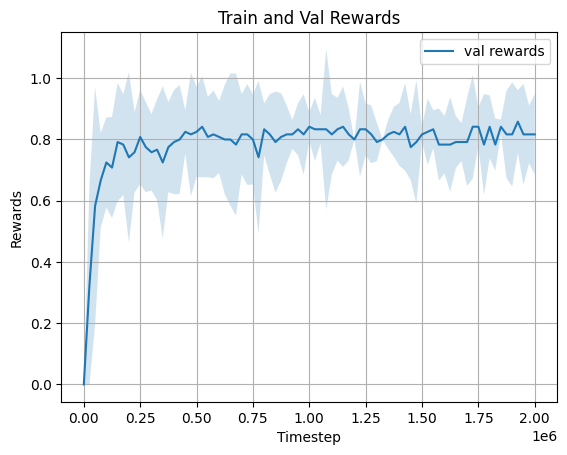

In [ ]:
val_lists = np.array(val_lists)

stds = []
for i in range(val_lists.shape[1]):
    stds.append(2 * np.std(val_lists[:, i]))

stds = np.array(stds)

plt.fill_between(np.arange(0, int(2e6) + 25000, 25000), np.mean(val_lists, axis=0) - stds, np.mean(val_lists, axis=0) + stds, alpha=0.2)
plt.plot(np.arange(0, int(2e6) + 25000, 25000), np.mean(val_lists, axis=0), label='val rewards')
plt.title("Train and Val Rewards")
plt.xlabel("Timestep")
plt.ylabel("Rewards")
plt.legend()
plt.grid();

In [ ]:
def make_gif(env, num_envs, model): 
    images = []
    rewards = []
    for i in range(num_envs):
        obs, _ = env.reset()
        img = env.render()
        done = False    
        ep_reward = 0 
        while not done:
            images.append(img)
            # state = obs_to_state(obs)
            q = model(torch.as_tensor(obs, dtype=torch.float32, device=device).view(1, 3, 19, 19)).cpu().detach().numpy() # WARNING: I coded this shape manually
            action = q.argmax()
            obs, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            done = terminated or truncated
            img = env.render()

        rewards.append(ep_reward)
        
    print(f'The mean over the env is {float(np.mean(rewards))}')
    imageio.mimsave('rendered_episode_sanity.gif', [np.array(img) for i, img in enumerate(images) if i%1 == 0], duration=200)

## Explore-Go vs Avoid Overlap 

In [7]:
from hashlib import sha1

class Transition:
    
    def __init__(
        self, 
        state: np.ndarray, 
        q_value: np.ndarray
    ):  
        self.state = state
        self.q_value = q_value
        
    def __eq__(self, other):
        return bool(np.all(self.state == other.state) and np.all(self.q_value == other.q_value))
    
    def __hash__(self):
        state_hash = int(sha1(self.state.flatten()).hexdigest(), 16)
        q_value_hash = int(sha1(self.q_value.flatten()).hexdigest(), 16)
        return hash((state_hash, q_value_hash))
    
class Trajectory: 
    
    def __init__(
        self
    ):
        self.transitions = []
        self.unique_transitions = set([])
    
    def add(self, transition: Transition):
        self.transitions.append(transition)
        self.unique_transitions.add(transition)
    
    def __eq__(self, other):
        if len(self.transitions) != len(other.transitions):
            return False
        return all(t1 == t2 for t1, t2 in zip(self.transitions, other.transitions))
    
    def __hash__(self):
        t_matrix_state = np.array([t.state for t in self.transitions]).flatten() 
        t_matrix_q = np.array([t.state for t in self.transitions]).flatten() 
        state_hash = int(sha1(t_matrix_state).hexdigest(), 16)
        q_value_hash = int(sha1(t_matrix_q).hexdigest(), 16)
        return hash((state_hash, q_value_hash))

    def uniqueness(self, other):
        intersection = self.unique_transitions.intersection(other.unique_transitions)
        return len(intersection) / len(self.transitions) # compares how unique is our trajectory compared to other
    
    def __iter__(self):
        return iter([(t.state, t.q_value) for t in self.transitions])
    
class ExploreGoDataset(Dataset):
    
    def __init__(self):
        super().__init__()
        
        self.trajectories = []
        self.unique_trajectories = set([])
        self.trans = []
        self.unique_trans = set([])
        self.current_traj = Trajectory()
        
    def wrap_trajectory(self):
        self.trajectories.append(self.current_traj)
        self.unique_trajectories.add(self.current_traj)
        for state, q in self.current_traj:
            self.add(state, q, None) # not storing the state
        self.current_traj = Trajectory()
        
    def reset(self): 
        self.current_traj = Trajectory()
    
    def add_traj(self, obs: np.ndarray, q_value: np.ndarray, state: np.ndarray):
        transition = Transition(obs, q_value)
        self.current_traj.add(transition)
        self.unique_trans.add(transition)
        
    def add_trans(self, obs: np.ndarray, q_value: np.ndarray):
        transition = Transition(obs, q_value)
        self.trans.append(transition)
        self.unique_trans.add(transition)
        
    def traj_uniqueness(self, trajectory: Trajectory): 
        unique = 0
        for traj in self.unique_trajectories:
            unique = max(unique, trajectory.uniqueness(traj))
        return unique  
    
    @property
    def ratio_unique_trans(self):
        return len(self.unique_trans) / len(self.trans)

In [ ]:
def create_explorego_dataset(dataset_size, save_dir, K=100, render=False):
    if render:
        env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= train_config['agent positions'],
                goal_pos = train_config['goal positions'],
                doors_pos = train_config['topologies'],
                agent_dir = train_config['agent directions'],
                size=size, 
                render_mode="rgb_array",
            ),
            original_obs=True
        )
    else:
        env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= train_config['agent positions'],
                goal_pos = train_config['goal positions'],
                doors_pos = train_config['topologies'],
                agent_dir = train_config['agent directions'],
                size=size, 
            ),
            original_obs=True
        )
    
    explorego = ExploreGoDataset()
    imgs = []
    
    ep_highlight_mask = np.zeros((len(train_config['agent positions']), 
                                      env.get_wrapper_attr('width'), env.get_wrapper_attr('height')), dtype=bool)
    ep_colors = np.empty_like(ep_highlight_mask, dtype=object)

    while len(explorego) <= dataset_size:
        
        obs, _ = env.reset()
        done = False
        
        # emulate the pure exploration of explorego
        max_k = len(env.get_wrapper_attr('valid_pos'))
        k = np.random.randint(low=0, high=max_k)
        env.get_wrapper_attr('move_valid_pos')(k)
        current_context = env.unwrapped.context
        print(f'Current size of dataset: {len(explorego)} | Current Context {current_context}', end='\r')
        
        # done_before = False
        # explore_steps = np.random.randint(low=0, high=K)
        # for _ in range(explore_steps):
        #     agent_pos = env.get_wrapper_attr('agent_pos')
            
        #     ep_highlight_mask[current_context, agent_pos[0], agent_pos[1]] = True
        #     ep_colors[current_context, agent_pos[0], agent_pos[1]] = (255, 128, 0)
        #     action = env.action_space.sample()
        #     obs, _, terminated, truncated, _ = env.step(action)
            
        #     done_before = terminated or truncated
        #     if render: imgs.append(env.render(highlight_mask=ep_highlight_mask[current_context], 
        #                                       colors=ep_colors[current_context]))
        #     if done_before:
        #         break
        
        # done = done_before
        
        # find optimal trajectory
        while not done:
            agent_pos = env.get_wrapper_attr('agent_pos')
            ep_highlight_mask[current_context, agent_pos[0], agent_pos[1]] = True
            ep_colors[current_context, agent_pos[0], agent_pos[1]] = (0, 204, 0)
            
            state = obs_to_state(obs)
            q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
            q = np.array(q)
            explorego.add_trans(np.array(obs), q)
            explorego.add(np.array(obs), q, np.array(state))
            obs_prime, _, terminated, truncated, _ = env.step(q.argmax())
            obs = obs_prime
            done = terminated or truncated
            if render and len(explorego) >= dataset_size - 10000: imgs.append(env.render(highlight_mask=ep_highlight_mask[current_context], 
                                              colors=ep_colors[current_context]))

    # save the obj       
    with open(f'action_values/{save_dir}.pl', 'wb') as file:
        dill.dump(explorego, file)
        
    return explorego, imgs

In [18]:
exploregorender, imgs = create_explorego_dataset(50000, 'explorego_render', render=True)

In [19]:
imageio.mimsave('renders/rendered_episode_explorego_50k.gif', [np.array(img) for i, img in enumerate(imgs[6000:]) if i%1 == 0], duration=100)

In [ ]:
create_explorego_dataset(25000, 'explorego_25k') # NOTE: i accidentally overwrote this so its now 80k
create_explorego_dataset(50000, 'explorego_50k')
create_explorego_dataset(80000, 'explorego_80k')

c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


(<__main__.ExploreGoDataset at 0x23fb4edf9d0>, [])

In [11]:
def create_avoid_dataset(dataset_size, save_dir, min_overlap=0.3, K=30, render=False):
    # storing avoid dataset
    overlapdataset = ExploreGoDataset()
    if render:
        env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= train_config['agent positions'],
                goal_pos = train_config['goal positions'],
                doors_pos = train_config['topologies'],
                agent_dir = train_config['agent directions'],
                size=size, 
                render_mode="rgb_array",
            ),
            original_obs=True
        )
    else:
        env = gym_wrapper(gym.make(
                'MiniGrid-FourRooms-v1', 
                agent_pos= train_config['agent positions'],
                goal_pos = train_config['goal positions'],
                doors_pos = train_config['topologies'],
                agent_dir = train_config['agent directions'],
                size=size, 
            ),
            original_obs=True
        )
    try:
        
    
        explorego = ExploreGoDataset()
        imgs = []
        
        ep_highlight_mask = np.zeros((len(train_config['agent positions']), 
                                        env.get_wrapper_attr('width'), env.get_wrapper_attr('height')), dtype=bool)
        ep_colors = np.empty_like(ep_highlight_mask, dtype=object)

        while len(explorego) <= dataset_size:
            
            obs, _ = env.reset()
            done = False
            
            # emulate the pure exploration of explorego
            max_k = len(env.get_wrapper_attr('valid_pos'))
            k = np.random.randint(low=0, high=max_k)
            env.unwrapped.move_valid_pos(k)
        
            current_context = env.unwrapped.context
            
            
            # find optimal trajectory
            past_pos = []
            while not done:
                agent_pos = env.get_wrapper_attr('agent_pos')

                state = obs_to_state(obs)
                q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
                q = np.array(q)
                
                transition = Transition(np.array(obs), q)
                if transition not in explorego.unique_trans:
                    explorego.add_trans(np.array(obs), q)
                    explorego.add(np.array(obs), q, np.array(state))
                    if render: 
                        ep_colors[current_context, agent_pos[0], agent_pos[1]] = (0, 0, 255)
                        ep_highlight_mask[current_context, agent_pos[0], agent_pos[1]] = True
                        past_pos.append(agent_pos)
                else:
                    if 1-explorego.ratio_unique_trans <= min_overlap:
                        explorego.add_trans(np.array(obs), q)
                        explorego.add(np.array(obs), q, np.array(state))
                        if render: 
                            ep_colors[current_context, agent_pos[0], agent_pos[1]] = (0, 0, 255)
                            ep_highlight_mask[current_context, agent_pos[0], agent_pos[1]] = True
                            past_pos.append(agent_pos)
                    else:
                        pass
                
                obs_prime, _, terminated, truncated, _ = env.step(q.argmax())
                obs = obs_prime
                done = terminated or truncated
                if render and len(explorego) >= dataset_size - 1000: imgs.append(env.render(highlight_mask=ep_highlight_mask[current_context], 
                                                colors=ep_colors[current_context]))
            if render:
                for pos in past_pos:
                    ep_colors[current_context, pos[0], pos[1]] = (51, 0, 102)

            print(f'Current size of dataset: {len(explorego):08d} | Current Context {current_context} | Current Uniqueness {explorego.ratio_unique_trans:.4f}', end='\r')

    except KeyboardInterrupt:
        with open(f'action_values/{save_dir}.pl', 'wb') as file:
            dill.dump(explorego, file)
        
    # save the obj       
    with open(f'action_values/{save_dir}.pl', 'wb') as file:
        dill.dump(explorego, file)
        
    print(explorego.ratio_unique_trans)
        
    return explorego, imgs

In [7]:
avoidrender, imgs = create_avoid_dataset(80000, 'avoid__render', min_overlap=0.5, render=True)

c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


In [10]:
imageio.mimsave('renders/rendered_episode_avoidgo_80k.gif', [np.array(img) for i, img in enumerate(imgs[-5000:]) if i%1 == 0], duration=100)

In [ ]:
avoidrender, imgs = create_avoid_dataset(50000, 'avoid__render', min_overlap=0.3, render=True)

In [ ]:
imageio.mimsave('renders/rendered_episode_avoidgo_50_03k.gif', [np.array(img) for i, img in enumerate(imgs[6000:]) if i%1 == 0], duration=100)

In [ ]:
create_avoid_dataset(25000, 'avoid_25k_05', min_overlap=0.5)
create_avoid_dataset(50000, 'avoid_50k_05', min_overlap=0.5)
create_avoid_dataset(80000, 'avoid_80k_05', min_overlap=0.5)
create_avoid_dataset(25000, 'avoid_25k_03', min_overlap=0.3)
create_avoid_dataset(50000, 'avoid_50k_03', min_overlap=0.3)
create_avoid_dataset(80000, 'avoid_80k_03', min_overlap=0.3)

c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


0.4984025559105431taset: 00000313 | Current Context 0 | Current Uniqueness 0.4984


c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


RUNNING EXPERIMENT comparison_explorego_1 ON DEVICE: cuda
=============Seed 0===============

For dataset: ExploreGo 25K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.350 | Hours left: 0.0ours left: 0.0

=============Seed 1===============

For dataset: ExploreGo 25K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.225 | Hours left: 0.0ours left: 0.0

=============Seed 2===============

For dataset: ExploreGo 25K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.375 | Hours left: 0.0ours left: 0.0

=============Seed 3===============

For dataset: ExploreGo 25K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.375 | Hours left: 0.0ours left: 0.0

Dataset: Avoid 25K (Fully Unique) | Test results: 0.6450
Dataset: Avoid 25K (Min Overlap 0.2) | Test results: 0.5813
Dataset: Avoid 25K (Min Overlap 0.4) | Test results: 0.5075
Dataset: ExploreGo 25K | Test results: 0.4050


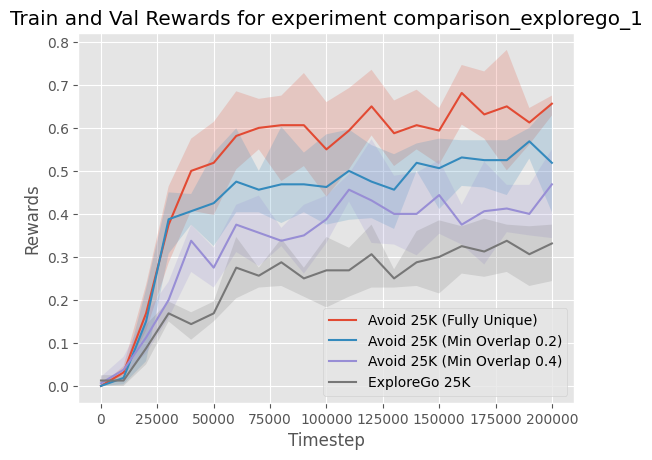

In [8]:
with open(f'action_values/avoid_25k.pl', 'rb') as file:
    avoid_full = dill.load(file)
    
with open(f'action_values/explorego_25k.pl', 'rb') as file:
    explore = dill.load(file)
    
with open(f'action_values/avoid_25k_02.pl', 'rb') as file:
    avoid_02 = dill.load(file)
    
with open(f'action_values/avoid_25k_04.pl', 'rb') as file:
    avoid_04 = dill.load(file)

avoid_vs_explorego = Experiment(
    'comparison_explorego_1', 
    seeds=[0, 1, 2, 3],
    timesteps=int(2e5), 
    val_freq=int(1e4),
    batch_size=64
)

avoid_vs_explorego.run_experiment([avoid_full, avoid_02, avoid_04, explore], 
                               ['Avoid 25K (Fully Unique)', 'Avoid 25K (Min Overlap 0.2)', 'Avoid 25K (Min Overlap 0.4)', 'ExploreGo 25K'])


RUNNING EXPERIMENT comparison_explorego2 ON DEVICE: cuda
=============Seed 0===============

For dataset: ExploreGo 50K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.575 | Hours left: 0.0ours left: 0.0

=============Seed 1===============

For dataset: ExploreGo 50K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.450 | Hours left: 0.0ours left: 0.0

=============Seed 2===============

For dataset: ExploreGo 50K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.475 | Hours left: 0.0ours left: 0.0

=============Seed 3===============

For dataset: ExploreGo 50K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.625 | Hours left: 0.0ours left: 0.0

Dataset: Avoid 50K (Fully Unique) | Test results: 0.7850
Dataset: Avoid 50K (Min Overlap 0.2) | Test results: 0.7600
Dataset: Avoid 50K (Min Overlap 0.4) | Test results: 0.7025
Dataset: ExploreGo 50K | Test results: 0.5375


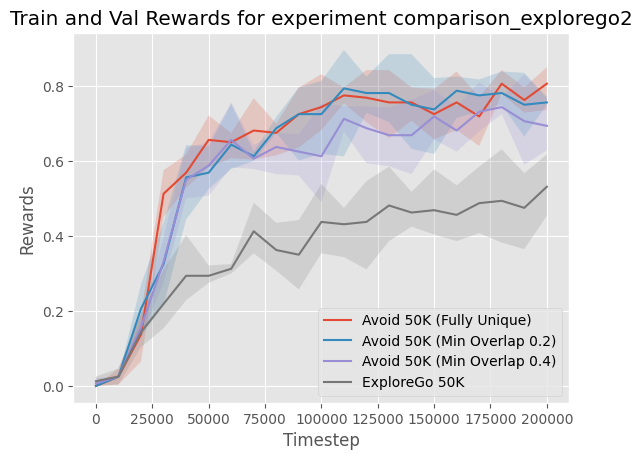

In [9]:
with open(f'action_values/avoid_50k.pl', 'rb') as file:
    avoid_full = dill.load(file)
    
with open(f'action_values/explorego_50k.pl', 'rb') as file:
    explore = dill.load(file)
    
with open(f'action_values/avoid_50k_02.pl', 'rb') as file:
    avoid_02 = dill.load(file)
    
with open(f'action_values/avoid_50k_04.pl', 'rb') as file:
    avoid_04 = dill.load(file)

avoid_vs_explorego = Experiment(
    'comparison_explorego2', 
    seeds=[0, 1, 2, 3],
    timesteps=int(2e5), 
    val_freq=int(1e4),
    batch_size=64
)

avoid_vs_explorego.run_experiment([avoid_full, avoid_02, avoid_04, explore], 
                               ['Avoid 50K (Fully Unique)', 'Avoid 50K (Min Overlap 0.2)', 'Avoid 50K (Min Overlap 0.4)', 'ExploreGo 50K'])


RUNNING EXPERIMENT comparison_explorego3 ON DEVICE: cuda
=============Seed 0===============

For dataset: ExploreGo 80K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.750 | Hours left: 0.0ours left: 0.0

=============Seed 1===============

For dataset: ExploreGo 80K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.550 | Hours left: 0.0ours left: 0.0

=============Seed 2===============

For dataset: ExploreGo 80K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.575 | Hours left: 0.0ours left: 0.0

=============Seed 3===============

For dataset: ExploreGo 80K || Step: 200000 / 200000 | Loss: 0.000 | Val Rewards: 0.475 | Hours left: 0.0ours left: 0.0

Dataset: Avoid 80K (Fully Unique) | Test results: 0.8287
Dataset: Avoid 80K (Min Overlap 0.2) | Test results: 0.7625
Dataset: Avoid 80K (Min Overlap 0.4) | Test results: 0.8013
Dataset: ExploreGo 80K | Test results: 0.5962


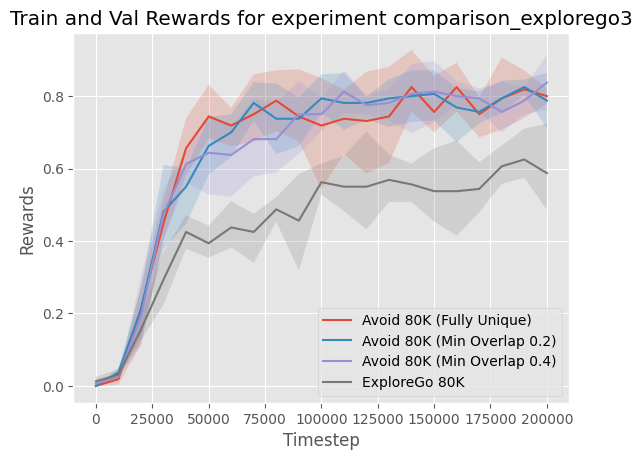

In [10]:
with open(f'action_values/avoid_80k.pl', 'rb') as file:
    avoid_full = dill.load(file)
    
with open(f'action_values/explorego_80k.pl', 'rb') as file:
    explore = dill.load(file)
    
with open(f'action_values/avoid_80k_02.pl', 'rb') as file:
    avoid_02 = dill.load(file)
    
with open(f'action_values/avoid_80k_04.pl', 'rb') as file:
    avoid_04 = dill.load(file)

avoid_vs_explorego = Experiment(
    'comparison_explorego3', 
    seeds=[0, 1, 2, 3],
    timesteps=int(2e5), 
    val_freq=int(1e4),
    batch_size=64
)

avoid_vs_explorego.run_experiment([avoid_full, avoid_02, avoid_04, explore], 
                               ['Avoid 80K (Fully Unique)', 'Avoid 80K (Min Overlap 0.2)', 'Avoid 80K (Min Overlap 0.4)', 'ExploreGo 80K'])


## Argmax Dataset vs Others 

RUNNING EXPERIMENT comparison_datasets_lower_batch32 ON DEVICE: cuda
=============Seed 0===============

For dataset: Balanced (Based on Unique Q-Values) || Step: 300000 / 300000 | Loss: 0.000 | Val Rewards: 0.550 | Hours left: 0.0

=============Seed 1===============

For dataset: Balanced (Based on Unique Q-Values) || Step: 300000 / 300000 | Loss: 0.000 | Val Rewards: 0.800 | Hours left: 0.0

=============Seed 2===============

For dataset: Balanced (Based on Unique Q-Values) || Step: 300000 / 300000 | Loss: 0.000 | Val Rewards: 0.600 | Hours left: 0.0

=============Seed 3===============

For dataset: Balanced (Based on Unique Q-Values) || Step: 300000 / 300000 | Loss: 0.000 | Val Rewards: 0.450 | Hours left: 0.0



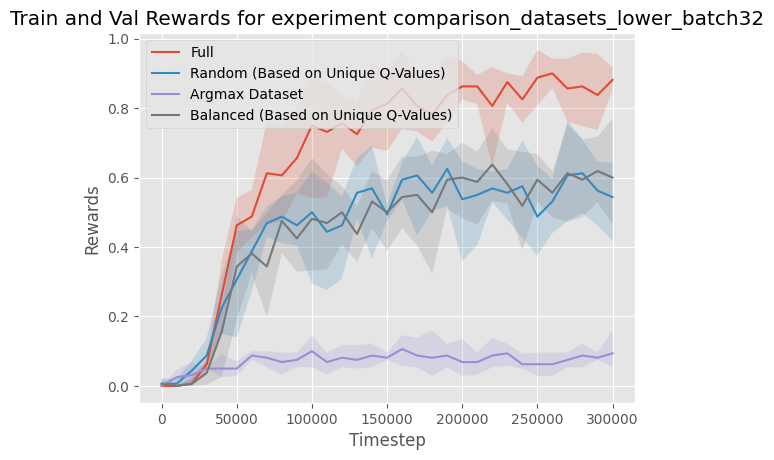

In [ ]:
full_comparison = Experiment(
    'comparison_datasets_lower_batch32', 
    seeds=[0, 1, 2, 3],
    timesteps=int(3e5), 
    val_freq=int(1e4),
    batch_size=32
)

full_comparison.run_experiment([dataset, random_dataset, argmax_dataset, train_dataset], 
                               ['Full', 'Random (Based on Unique Q-Values)', 'Argmax Dataset', 'Balanced (Based on Unique Q-Values)'])


## Data Augmentation Consistency Reg

In [13]:
# collect DAC data

env = gym_wrapper(gym.make(
        'MiniGrid-FourRooms-v1', 
        agent_pos= train_config['agent positions'],
        goal_pos = train_config['goal positions'],
        doors_pos = train_config['topologies'],
        agent_dir = train_config['agent directions'],
        size=size, 
        max_steps=1200, 
    ),
    original_obs=True
)

dac_argmax = ExploreGoDataset()
dac_augmented = ExploreGoDataset()



try:
    # first collect argmax dataset
    for i in range(len(train_config['topologies'])):
        obs, _ = env.reset() 
        done = False    
        
        print(f'Argmax: Context is {i+1}, dataset len: {len(dac_argmax)}', end='\r')
        while not done:    
            state = obs_to_state(obs)
            q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
            q = np.array(q)
            obs_prime, _, terminated, truncated, _ = env.step(q.argmax())
            dac_argmax.add_trans(np.array(obs), q)
            dac_argmax.add(np.array(obs), q, np.array(state))
            obs = obs_prime
            done = terminated or truncated

    # collect augmented
    print('\n')
    for i in range(len(train_config['topologies'])):

        obs, _ = env.reset() 
        done = False 
        
        print(f'Augmented: Context is {i+1}, dataset len: {len(dac_augmented)}', end='\r')
        for idx in range(len(env.unwrapped.valid_pos)):
            env.unwrapped.move_valid_pos(idx)
            
            for _ in range(4): 
                obs, _, _, _, _ = env.step(1)
                state = obs_to_state(obs)
                q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
                transition = Transition(np.array(obs), np.array(q))
                if transition not in dac_argmax.unique_trans: # ignore transition if its in the argmax dataset
                    dac_augmented.add_trans(np.array(obs), np.array(q))
                    dac_augmented.add(np.array(obs), np.array(q), np.array(state))
        
            
except KeyboardInterrupt:
    pass

with open('action_values/dac_argmax.pl', 'wb') as file:
    dill.dump(dac_argmax, file)
    
with open('action_values/dac_augmented.pl', 'wb') as file:
    dill.dump(dac_augmented, file)

c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):


Argmax: Context is 200, dataset len: 3040



In [99]:
class DACRegression(RegressionModel):
    
    def __init__(
        self, 
        env, 
        val_env, 
        dac_reg: float = 5, 
        *args, 
        **kwargs
    ):
        super().__init__(env, val_env, *args, **kwargs)
        
        self.dac_loss = nn.MSELoss()
        self.dac_reg = dac_reg
        
        
    def run(
        self, 
        dataset: ExploreGoDataset, 
        augmented_dataset: ExploreGoDataset,
        label: str, 
        timesteps: int = int(1e5), 
        batch_size: int = 1024, 
        val_freq: int = 5000,
        print_freq: int = 1000, 
        dac_batch: int = 1 # right now one or else I have to do the expectation
    ): 
        uniques = np.unique(np.array(dataset.Y), axis=0).astype(np.float32)
        
        # do the sorting manually due to precision faults
        augmented_dict = defaultdict(list)
        
        X = np.array(dataset.X)
        Y = np.array(dataset.Y)
        
        for q in np.unique(Y, axis=0):
            mask = np.all(Y == q, axis=1)
            augmented_dict[tuple(q.astype(np.float32))] = X[mask]
        
        augmented_dict_torch = {}
        for unique in uniques:
            # bad typing i forgot to take this into account
            augmented_dict_torch[tuple(unique)] = torch.as_tensor(np.array(augmented_dict[tuple(unique)]), device=self.device, 
                                                                  dtype=torch.float32)
        
        n_samples = len(dataset)
        
        X_argmax = torch.as_tensor(np.array(dataset.X), dtype=torch.float32, device=self.device)
        y_argmax = torch.as_tensor(np.array(dataset.Y), dtype=torch.float32, device=self.device)
        
        val_rewards = []
        start_time = time.time()
        for step in range(timesteps+1):
            batch_idx = torch.randint(0, n_samples, (batch_size,), device=self.device)
            batch_x_argmax = X_argmax[batch_idx]
            batch_y_argmax = y_argmax[batch_idx]
            
            preds_argmax = self(batch_x_argmax)
            loss_argmax = self.loss(preds_argmax, batch_y_argmax)
            
            if len(augmented_dataset) > 0:
                batch_y_numpy = batch_y_argmax.cpu().numpy()
                augmented_batch_x = []
                for y in batch_y_numpy:
                    augmented_states = augmented_dict_torch[tuple(y)]
                    idx = torch.randint(low=0, high=len(augmented_states), size=(min(len(augmented_states), dac_batch),))
                    augmented_batch_x.append(augmented_states[idx])
                
                augmented_batch_x = torch.cat(augmented_batch_x, dim=0)
                augmented_preds = self(augmented_batch_x)
                
                loss_augmented = self.dac_loss(preds_argmax.detach(), augmented_preds)
            else: 
                loss_augmented = 0 
            
            loss = loss_argmax + self.dac_reg * loss_augmented
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if step % val_freq == 0:
                val_reward = self.validation()
                val_rewards.append(val_reward)
                
            if step % print_freq == 0:
                total_time = (time.time() - start_time) / print_freq 
                time_left = ((timesteps - step) * total_time) / 3600
                start_time = time.time() 
                
                print(f'For dataset: {label} || Step: {step} / {timesteps} | Loss: {loss.item():.3f} | Val Rewards: {val_reward:.3f} | Hours left: {time_left:.1f}',
                  end='\r')
            
        return val_rewards
    
    
class DACExperiment(Experiment):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def run_experiment(
        self, 
        argmax_dataset: ExploreGoDataset, 
        augmented_dataset: ExploreGoDataset,
        augmented_sizes: list, 
        labels: list 
    ):
        results = [[] for _ in range(len(augmented_sizes))]
        
        try: 
            torch.backends.cudnn.deterministic = True
            
            print(f'RUNNING EXPERIMENT {self.exp_name} ON DEVICE: {self.device}')
            for seed in self.seeds: 
                random.seed(seed)
                np.random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)
                
                print(f'=============Seed {seed}===============\n')
                
                for i, size in enumerate(augmented_sizes):
                    new_augmented = ExploreGoDataset()
                    idxs = np.random.randint(low=0, high=len(augmented_dataset), size=(size))
                    new_augmented.X = np.array(augmented_dataset.X)[idxs]
                    new_augmented.Y = np.array(augmented_dataset.Y)[idxs]
                    
                    model = DACRegression(self.env, self.val_env, device=device).to(device=device)
                    val_rewards = model.run(argmax_dataset, new_augmented, timesteps=self.timesteps, 
                                            val_freq=self.val_freq, print_freq=self.val_freq, label=labels[i], 
                                            batch_size=self.batch_size)
                    results[i].append(val_rewards)
                print('\n')    
            self.plot_result(results, labels)
            self.save_results(results)
            
        except KeyboardInterrupt: 
            print('Experiment stopped prematurely')
            self.close()

RUNNING EXPERIMENT comparison_dac ON DEVICE: cuda
=============Seed 0===============

For dataset: Argmax || Step: 150000 / 150000 | Loss: 0.000 | Val Rewards: 0.050 | Hours left: 0.0 0.0

=============Seed 1===============

For dataset: Argmax || Step: 150000 / 150000 | Loss: 0.000 | Val Rewards: 0.050 | Hours left: 0.0 0.0



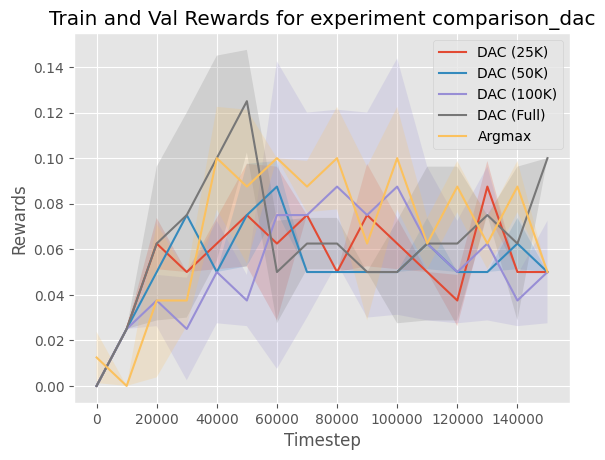

In [105]:
with open(f'action_values/dac_argmax.pl', 'rb') as file:
    dac_argmax = dill.load(file)
    
with open(f'action_values/random_dataset.pl', 'rb') as file:
    dac_augmented = dill.load(file)

dac_exp = DACExperiment(
    exp_name='comparison_dac', 
    seeds=[0, 1],
    timesteps=int(1.5e5), 
    val_freq=int(1e4),
    batch_size=64
)

dac_exp.run_experiment(dac_argmax, dac_augmented, [int(2.5e4), int(5e4), int(1e5), len(dac_augmented), 0], 
                               ['DAC (25K)', 'DAC (50K)', 'DAC (100K)', 'DAC (Full)', 'Argmax'])
